In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, linear
from keras.layers import Dense, Dropout, Conv1D, MaxPooling2D, Activation, Flatten, Embedding, Reshape,MaxPooling1D,LeakyReLU
!pip install yfinance
import yfinance as yf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 4.6 MB/s eta 0:00:00


In [2]:
Crypto_name = ["BTC-USD"] # replace with other crypto currency e.g. "ETH-USD" 'XRP-USD' "LTC-USD"
start_date="2022-06-20"
end_date='2023-06-20'
closing_price=pd.DataFrame()
for i in Crypto_name:
    data= yf.Ticker(i)
    data = data.history(start=start_date , end=end_date,interval="1h")
    colse=pd.DataFrame(data.Close)
    closing_price[i] = colse

# Plot the closing changes 

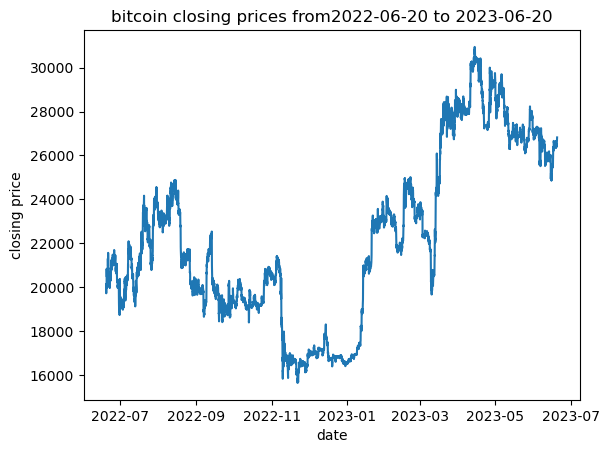

In [3]:
# plot the closing price changes in the given period
plt.xlabel("date")
plt.ylabel("closing price")
plt.title(f"bitcoin closing prices from{start_date} to {end_date}")
plt.plot(closing_price['BTC-USD'])


# Generate the action space

[-20.  -19.2 -18.4 -17.6 -16.8 -16.  -15.2 -14.4 -13.6 -12.8 -12.  -11.2
 -10.4  -9.6  -8.8  -8.   -7.2  -6.4  -5.6  -4.8  -4.   -3.2  -2.4  -1.6
  -0.8   0.    0.8   1.6   2.4   3.2   4.    4.8   5.6   6.4   7.2   8.
   8.8   9.6  10.4  11.2  12.   12.8  13.6  14.4  15.2  16.   16.8  17.6
  18.4  19.2  20. ]


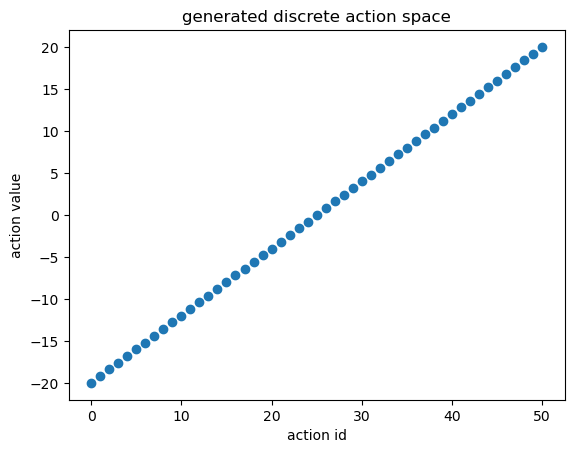

In [4]:
import gym
from gym import spaces
action_choices = np.linspace(-20, 20, num=51) # using linespace to generate 25 actions to buy or sell in [0.5$,20$] interval
print(action_choices)
plt.xlabel("action id")
plt.ylabel("action value")
plt.title(f"generated discrete action space")
plt.scatter([act for act in range(len(action_choices))],action_choices)

# Define the DQN agent (double DQN)

In [5]:
class DQNAgent :
    def __init__(self, state_size, action_size,batch_size,update_target_interval=100):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(1000000,state_size,action_size)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min =0.1
        self.epsilon_decay = 0.995
        self.batch_size = batch_size
        self.learning_rate = 0.001
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        
        self.update_target_interval =update_target_interval
        self.update_target_counter=0
        
    def _build_model(self):
        model = Sequential()
        model.add(Conv1D(128,8, input_shape=(self.state_size,1), padding='same'))
        model.add(LeakyReLU())
        model.add(MaxPooling1D(2, padding='same'))
        model.add(Conv1D(64,8, padding='same'))
        model.add(LeakyReLU())
        model.add(Flatten())
        model.add(Dense(384))
        model.add(Activation('relu'))
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(Dense(self.action_size, activation='linear')) 
        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate), metrics=['accuracy'])
        return model

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)
        
    def act(self, state,test_mode=False):
        if not test_mode:
            if np.random.rand() <= self.epsilon :
                return random.randrange(self.action_size)
        act_values = self.model.predict(np.expand_dims(state,axis=0), verbose=0)
        return np.argmax(act_values[0])
    
    def train(self, batch_size) :
        if self.memory.mem_cntr  < batch_size:
            return
        state, action, reward, new_state, done = self.memory.sample_buffer(batch_size)
        
        qState=self.model.predict(state,verbose=0)
        qNextState=self.model.predict(new_state,verbose=0)
        qNextStateTarget=self.target_model.predict(new_state,verbose=0)
        maxActions=np.argmax(qNextState,axis=1)
        batchIndex = np.arange(batch_size, dtype=np.int32)
        qState[batchIndex,action]=(reward+(self.gamma*qNextStateTarget[batchIndex,maxActions.astype(int)]*(1-done)))
        _=self.model.fit(x=state,y=qState,verbose=0,epochs=65)

        self.update_target_counter+=1
        if self.update_target_counter % self.update_target_interval==0 :
            self.target_model.set_weights(self.model.get_weights())
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
class TradingEnv(gym.Env) :
    def __init__(self, init_capital=2500, stock_price_history=[], window_size=24):
        self.init_capital = init_capital
        self.stock = 0
        self.stock_price_history = stock_price_history
        self.window_size = window_size
        self.current_step = 0
        self.action_space = spaces.Discrete(61)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.window_size,))
        self.reset()
        
    def reset(self) :
        self.current_step = 0
        self.stock = 0
        self.capital = self.init_capital
        return self._next_observation()
    
    def _next_observation(self):
        prices = self.stock_price_history[self.current_step:self.current_step+self.window_size]
        return np.array(prices)
    
    def step(self, action):
        stock_price = self.stock_price_history[self.current_step+self.window_size]
        portfolio_value=(self.capital + self.stock * stock_price)
        if action > 0 and action <= self.capital :
            self.capital -= action
            self.stock += action/stock_price
        elif action < 0 and (self.stock * stock_price)>(-action):
            self.stock += action/stock_price                        
            self.capital -= action
        reward = (self.capital + self.stock * self.stock_price_history[self.current_step+self.window_size+1]) - portfolio_value
        self.current_step += 1
        done = self.current_step+self.window_size + 2 >= len(self.stock_price_history)
        return self._next_observation(), reward, done, (self.capital + self.stock * self.stock_price_history[self.current_step+self.window_size+1])